In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
import itertools

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('bmh')

# Generate time series

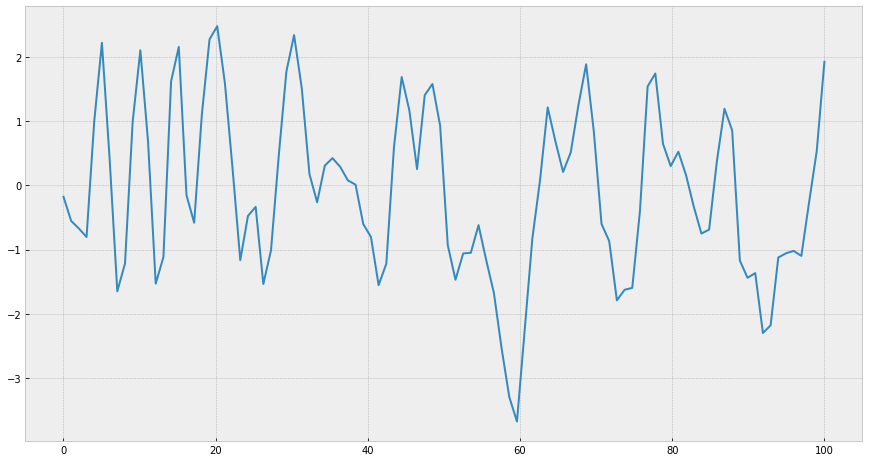

In [20]:
from statsmodels.tsa.arima_process import arma_generate_sample

nsample = 100
x1 = np.linspace(0, 100, nsample)

arparams = np.array([.75, -.25])
maparams = np.array([.65, .35])
arparams = np.r_[1, -arparams]
maparam = np.r_[1, maparams]

y = arma_generate_sample(arparams, maparams, nsample)
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(x1, y, label="Data") 

# Decomposition plot

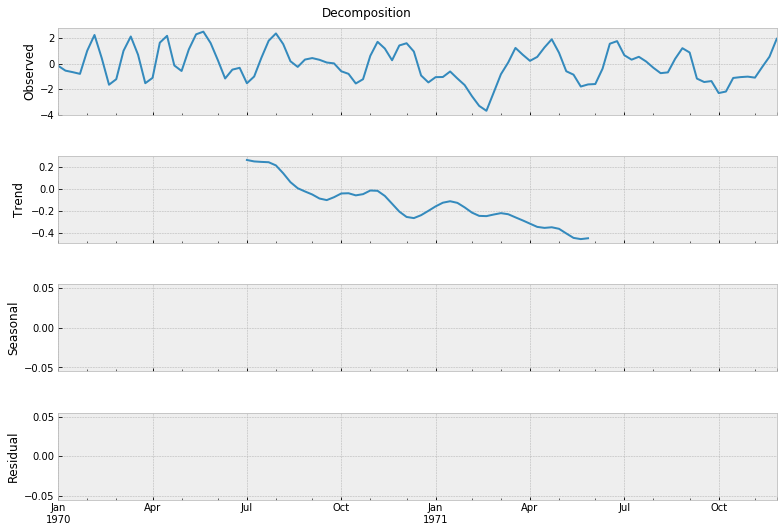

In [21]:
serie =  pd.DataFrame(y)
serie.index = pd.DatetimeIndex(freq='w', start=0, periods=nsample)

decomposition = sm.tsa.seasonal_decompose(serie, model='additive')

fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition')
plt.show()

# ARIMA modeling

In [22]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

## Select model

In [27]:
import sys
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:

    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(serie,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=True,
                                             enforce_invertibility=True)

            results = temp_model.fit()

            #print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(1, 0, 1)x(1, 0, 0, 12)12 model - AIC:225.4135940912907


## Model

In [33]:
best_model = sm.tsa.statespace.SARIMAX(serie,
                                      order=best_pdq,
                                      seasonal_order=best_seasonal_pdq,
                                      enforce_stationarity=True,
                                      enforce_invertibility=True)

best_results = best_model.fit()

print(best_results.summary().tables[0])
print(best_results.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                                  0   No. Observations:                  100
Model:             SARIMAX(1, 0, 1)x(1, 0, 0, 12)   Log Likelihood                -108.707
Date:                            Wed, 16 Aug 2017   AIC                            225.414
Time:                                    20:15:48   BIC                            235.834
Sample:                                01-04-1970   HQIC                           229.631
                                     - 11-28-1971                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5596      0.102      5.508      0.000       0.360       0.759
ma.L1          0.7515      0.079   